# here is the analysiss of the processfile to find important residues

In [1]:
import pandas as pd
pd.options.display.max_rows = 20
import numpy as np
import matplotlib.pyplot as plt
import collections
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from scipy import histogram, digitize, stats, mean, std
import sys
import statsmodels.api as sm
from sklearn import linear_model,preprocessing ,decomposition
from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler #used custom one
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

In [2]:
test = pd.read_csv('./processed/stapled_peptide_permability_features.csv')
test = test[test['Peptide_type'] != 1].reset_index(drop=True)
test = test[test['sequence'] != '-AC-AHL-R8-LCLEKL-S5-GLV-(K-PEG1--FITC-)'].reset_index(drop=True)
test['Lg_Flr'] = np.log10(test['Mean_Flr_intensity'])
del test['permability']

In [3]:
# function process sequence into list
def process_string(str,len=len):
    result = []
    special_resi = False
    for i in str:
        if i =='(':
            return len(result)
        elif special_resi and i !='-': #inside special residue
            temp += i
        elif i =='-':
            if special_resi : #closing of special residue
                result += [temp,]
                special_resi = False
                temp  = ''
            else: #starting of special residue
                special_resi = True 
                temp = ''
        else: #normal residue
            result += [i,]
            #if i in ['Q','N']:
                #result += [i,]
    return len(result)


In [4]:
# more features 
if True:
    test['len']=test['sequence'].apply(process_string)
    test['res_list']=test['sequence'].apply(lambda x : process_string(x,list))
    test['list']=test['sequence'].apply(lambda x : np.array(process_string(x,list)))
    test['res_list_QN']=test['res_list'].apply(lambda x : collections.Counter(x)['Q']+collections.Counter(x)['N'])
    test['res_list']=test['res_list'].apply(len)
    dictt = collections.Counter(np.concatenate(test['list'].values))
    test['Aro_Ccycle_num'] = test['SMILES'].apply(lambda x :\
        Descriptors.NumAromaticCarbocycles(Chem.MolFromSmiles(x)))
    test['Aro_Hcycle_num'] = test['SMILES'].apply(lambda x :\
        Descriptors.NumAromaticHeterocycles(Chem.MolFromSmiles(x)))
    test['Aro_Ring_num'] = test['SMILES'].apply(lambda x :\
        Descriptors.NumAromaticRings(Chem.MolFromSmiles(x)))
    test['Ali_Ccycle_num'] = test['SMILES'].apply(lambda x :\
        Descriptors.NumAliphaticCarbocycles(Chem.MolFromSmiles(x)))
    test['Ali_Hcycle_num'] = test['SMILES'].apply(lambda x :\
        Descriptors.NumAliphaticHeterocycles(Chem.MolFromSmiles(x)))
    test['Ali_Ring_num'] = test['SMILES'].apply(lambda x :\
        Descriptors.NumAliphaticRings(Chem.MolFromSmiles(x)))
    for i in [x for x in test.keys() if ('Ali' in x or 'Aro' in x)]:
        test[i[:-4]+'_norm'] = test[i]/test['res_list']
    test['TPSA-DIV-LabuteASA'] = test['TPSA']/test['LabuteASA'] #ratio of polar SA


def get_surface_area(smile):
    #print (smile[-25:])
    mol0 = Chem.MolFromSmiles(smile)
    mol = Chem.AddHs(mol0)
    AllChem.Compute2DCoords(mol)
    adj = (Chem.GetDistanceMatrix(mol)==1)*1
    adj2 = (Chem.GetDistanceMatrix(mol)==2)*1
    molMMFF = AllChem.MMFFGetMoleculeProperties(mol)
    # Chem.MolSurf._LabuteHelper(mol) indiv contribution of surface area
    atoms = list(
                            map(lambda x: molMMFF.GetMMFFAtomType(x),
                                range(len(mol.GetAtoms()))
                                 )
                            )
    AllChem.ComputeGasteigerCharges(mol)
    charges = np.array([float(mol.GetAtomWithIdx(x).GetProp('_GasteigerCharge')) for x in range(len(atoms))])
    surf= np.array(Chem.MolSurf._LabuteHelper(mol))
    return (charges,surf[1:],atoms)
test['charge_surf'] = test['SMILES'].apply( get_surface_area)
test['charge_num'] = test['charge_surf'].apply(lambda x : np.sum(x[0]))
test['charge_mean'] = test['charge_surf'].apply(lambda x : np.mean(x[0]))

#combine similar amino acids together
dictt_vol = {'FITC': 163.32732360530238, 'PEG2': 75.972, 'pff': 84.691, 'Y': 68.658, 'I': 47.901,
             'E': 50.492, 'A': 28.806, 'P': 40.74, 'L': 47.901, 'AC': 16.891, 'B8': 71.665, 'B88': 146.863,
             'S5': 53.418, 'BAla': 28.806, 'PEG': 58.128, 'S': 33.6, 'D': 44.127, 'EEA': 93.299, 'F': 63.863,
             'R8': 72.513, 'T': 39.965, 'R5': 50.236, 'NL': 47.901, 'N': 44.673, 'Q': 51.038, 'R88': 115.722,
             'S8': 72.513, 'C': 39.961, 'B5': 71.665, 'G': 22.441, 'K': 53.241, 'R': 63.476, 'PEG1': 58.128,
             'W': 79.754, 'M': 51.659, 'V': 35.171, 'PEG5': 135.867, 'H': 56.292}
for i in [('W','F','Y','pff'),('N','Q'),('L','I','V','NL'),('D','E'),
          ('S8','R8','B8'),('R5','S5'),('PEG2','PEG5','PEG1'),
          ('R','K'),('H','R','K'),('S','T'),('S8','R8'),('S8','B8'),('R8','B8'),
          ('W','F','pff'),('F','pff'),('F','Y')]:
    dictt[i] = 999

#feature for each aa groups
for res in dictt.keys():
        test['%s_num' %str(res)] = test['list'].apply(lambda x : sum(np.in1d(x,np.array(res))))
        test['%s_norm' %str(res)] = 1.0*test['%s_num'%str(res)]/test['res_list']
        test['%s_normSA' %str(res)] = test['list'].apply(lambda y: np.array(list(map(lambda x : dictt_vol[x],y)))).apply(np.sum) #total area
        test['%s_normSA' %str(res)] = test['list'].apply(lambda y : sum(np.array(list(map(lambda x : dictt_vol[x],y)))[np.in1d(y,np.array(res))]))\
                                      /test['list'].apply(lambda y: np.array(list(map(lambda x : dictt_vol[x],y)))).apply(np.sum)

print ('frequencies of each amino acid：',dictt)

frequencies of each amino acid： Counter({('F', 'pff'): 999, ('PEG2', 'PEG5', 'PEG1'): 999, ('D', 'E'): 999, ('R8', 'B8'): 999, ('S8', 'R8'): 999, ('S8', 'R8', 'B8'): 999, ('W', 'F', 'Y', 'pff'): 999, ('R5', 'S5'): 999, ('H', 'R', 'K'): 999, ('S8', 'B8'): 999, ('S', 'T'): 999, ('N', 'Q'): 999, ('W', 'F', 'pff'): 999, ('F', 'Y'): 999, ('L', 'I', 'V', 'NL'): 999, ('R', 'K'): 999, 'R': 545, 'L': 320, 'S5': 267, 'Q': 206, 'FITC': 193, 'E': 188, 'BAla': 172, 'A': 168, 'I': 142, 'F': 141, 'S': 132, 'N': 121, 'K': 119, 'V': 104, 'D': 103, 'T': 80, 'H': 73, 'R8': 65, 'W': 44, 'G': 43, 'S8': 42, 'B5': 36, 'Y': 34, 'P': 32, 'C': 26, 'M': 18, 'NL': 17, 'R5': 14, 'pff': 9, 'PEG2': 8, 'PEG1': 5, 'PEG5': 5, 'B8': 3, 'EEA': 3})


In [5]:
# Import pairwise2 module
from Bio import pairwise2

# Import format_alignment method
from Bio.pairwise2 import format_alignment
dictt_counter = {}
counter =0
# convert the amino acids into single letter for sequence anaylsis,as some amino acids contain  > 1 letters
string='abcdefghijklmnopqrstuvwxyz1234567890!@#$%^&*()'
for i in sorted(dictt,key=lambda x : dictt[x])[::-1]:
  if type(i) != tuple:  
    dictt_counter[i] = string[counter]
    counter += 1
def func(x):
    result = ''
    for i in x:
        result += dictt_counter[i]
    return result
test['string'] = test['list'].apply(func)


In [6]:
corr_mat = np.zeros((len(test),len(test)))
# Define two sequences to be aligned
for i in range(len(test)):
    for j in range(i,len(test)):
        alignments = pairwise2.align.globalms(test.iloc[i]['string'],
                                             test.iloc[j]['string'],
                                              2, -1, -0.5, -0.1)
        alignments = sorted(alignments,key= lambda x : x[-3])[-1]
        score = 2*np.sum(np.array(list(map(lambda x : x,alignments[0])))==np.array(list(map(lambda x : x,alignments[1]))))
        corr_mat[i,j] = score/(len(test.iloc[i]['string'])+len(test.iloc[j]['string']))
        corr_mat[j,i] = score/(len(test.iloc[i]['string'])+len(test.iloc[j]['string']))


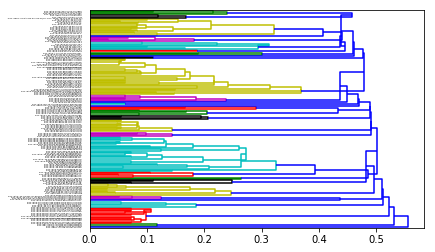

In [7]:
if True:
    import scipy.spatial.distance as ssd
    heat_map = abs(corr_mat-1)
    import scipy.cluster.hierarchy as sch
    from scipy.cluster.hierarchy import fcluster
    Y = sch.linkage(ssd.squareform(heat_map),method='centroid')
    Z = sch.dendrogram(Y,orientation='right')
    index = Z['leaves']
    D = heat_map[index,:]
    D = D[:,index]
    sorted_keys = [test.iloc[x]['sequence'] for x in index]
    plt.close()
    plt.xticks(range(len(index)),sorted_keys,rotation='vertical', fontsize=2)
    plt.yticks(range(len(index)),sorted_keys, fontsize=2)
    plt.imshow(D);plt.savefig('../reports/figures/cluster_peptide.png',dpi=300, bbox_inches='tight');#plt.show()
    plt.close()
    Z = sch.dendrogram(Y,orientation='right')
    plt.yticks(np.array(range(1,1+len(index)))*10-5,sorted_keys, fontsize=2)
    plt.savefig('../reports/figures/cluster_peptide.png',dpi=300)
plt.show()

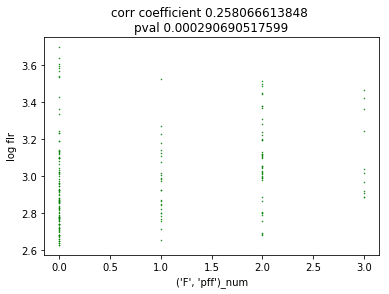

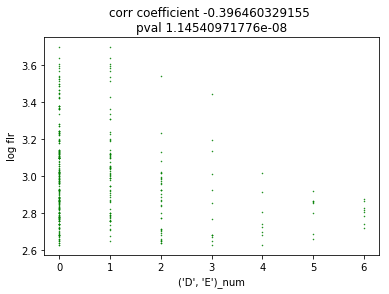

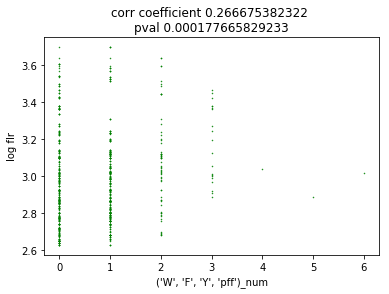

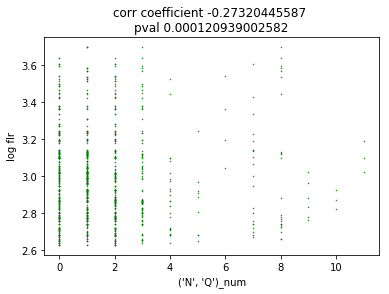

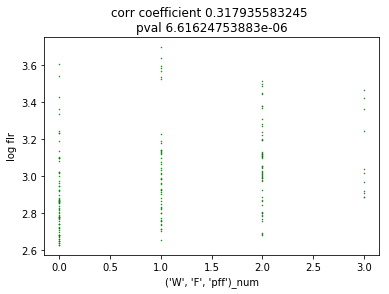

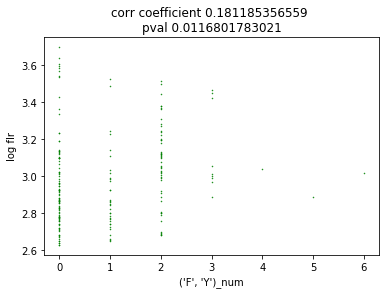

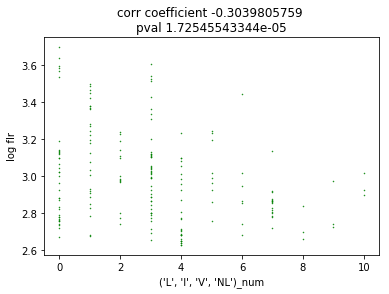

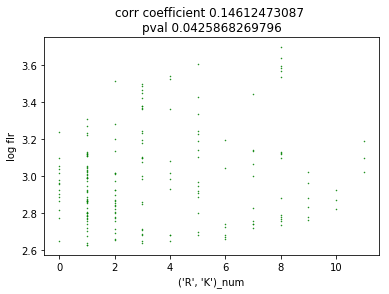

In [8]:
#plot each residue vs log flourscnecne
import scipy
for i in list(test.keys()):
    if 'num' in i and '(' in i :
        plt.plot(test[i],test['Lg_Flr'],'go',markersize=.5)
        plt.xlabel(i)
        plt.ylabel('log flr')
        pval = scipy.stats.pearsonr(test[i],test['Lg_Flr'])
        if pval[1] > 0.05:
            continue
        plt.title('corr coefficient %s \npval %s'%(pval[0],pval[1]))
        plt.savefig('../reports/figures/'+i+'.png',dpi=300)
        plt.show()
        plt.close()

In [9]:
class StandardScaler(object):
    #custom weighted scale function
    def fit(self,X,weights):
        if type(weights)==type(None):
            mean = np.mean(X, 0).values
            std = np.std(X, 0).values
        else:
            weights= np.array([weights,]*X.shape[1]).T
            mean = np.sum(np.array(weights)*np.array(X),0)/np.sum(np.array(weights),0)
            std = np.sum(np.array(weights)*((np.array(X)-mean)**2),0)/np.sum(np.array(weights),0)
            std = std**.5
        self.mean = mean
        self.std = std
        return self
    def transform(self,X):
        return (X.values-self.mean)/self.std

In [10]:
def plot_LR_coefficient(results,cutoff,test):
    reg_coef = pd.DataFrame(results,columns= \
                            ['name','simple LR model R2','corr coef','Se','CI','present in ids']).\
                            sort_values('simple LR model R2').reset_index(drop=True)
    features = []
    if True:
        plt.close()
        counter = 1
        plots = []
        for i in [x for x in sorted(results,key =  lambda x : x[-4])[-250:]]:
                if i[2] < -0.01 and 'num' in i[0] and '.(' not in i[0]:
                        features += [i[0],]
                        plots += [i,]
                        plt.errorbar([i[-4],],[counter,]*1,xerr=i[-3],fmt='r')
                        plt.plot([i[-4],],[counter,]*1,'ro')
                        if i[-4]-1.19*i[-3] > 0 or  i[-4]+1.19*i[-3] < 0:
                            txt = i[0]+'***'
                        elif i[-4]-i[-3] > 0 or i[-4]+i[-3] < 0:
                            txt = i[0]+'**'
                        else:
                            txt = i[0]+'*'
                        plt.text(i[-4],counter+.25,txt,horizontalalignment='center',fontsize=5)
                        counter += 1
        try:
            i = [x for x in sorted(results,key =  lambda x : x[-4]) if 'res_list' in x[0]][0]
            plots += [i,]
            plt.errorbar([i[-4],],[counter,]*1,xerr=i[-3],fmt='g')
            plt.plot([i[-4],],[counter,]*1,'go')
            if i[-4]-1.19*i[-3] > 0 or  i[-4]+1.19*i[-3] < 0:
                txt = i[0]+'***'
            elif i[-4]-i[-3] > 0 or i[-4]+i[-3] < 0:
                txt = i[0]+'**'
            else:
                txt = i[0]+'*'
            plt.text(i[-4],counter+.25,'Number of residues**',horizontalalignment='center',fontsize=5)
            counter += 1
        except : None
        for i in [x for x in sorted(results,key =  lambda x : x[-4])[-250:]]:
                if i[2] > 0.01 and 'num' in i[0] and '.(' not in i[0]:
                        features += [i[0],]
                        plots += [i,]
                        plt.errorbar([i[-4],],[counter,]*1,xerr=i[-3],fmt='b')
                        plt.plot([i[-4],],[counter,]*1,'bo')
                        if i[-4]-1.19*i[-3] > 0 or  i[-4]+1.19*i[-3] < 0:
                            txt = i[0]+'***'
                        elif i[-4]-i[-3] > 0 or i[-4]+i[-3] < 0:
                            txt = i[0]+'**'
                        else:
                            txt = i[0]+'*'
                        plt.text(i[-4],counter+.25,txt,horizontalalignment='center',fontsize=5)
                        counter += 1
        plt.title('Number Features, cutoff: '+str(cutoff))
        plt.xlabel('Coefficient and 95% CI of feature')
        plt.ylabel('Number Features')
        plt.yticks([],[])
        plt.ylim([0,counter])
        plt.savefig('../reports/figures/B_coef_cutoff:_'+str(cutoff)+'.png',dpi=300),plt.show()
        plt.close()
        counter = 1
        plots = []
        for i in [x for x in sorted(results,key =  lambda x : x[-4])[-250:]]:
                if i[2] < -0.01 and 'num' not in i[0] and 'list' not in i[0] and 'normSA' not in i[0] and 'VSA' not in i[0]:
                        features += [i[0],]
                        plots += [i,]
                        plt.errorbar([i[-4],],[counter,]*1,xerr=i[-3],fmt='r')
                        plt.plot([i[-4],],[counter,]*1,'ro')
                        if i[-4]-1.19*i[-3] > 0 or  i[-4]+1.19*i[-3] < 0:
                            txt = i[0]+'***'
                        elif i[-4]-i[-3] > 0 or i[-4]+i[-3] < 0:
                            txt = i[0]+'**'
                        else:
                            txt = i[0]+'*'
                        plt.text(i[-4],counter+.25,txt,horizontalalignment='center',fontsize=5)
                        counter += 1
        for i in [x for x in sorted(results,key =  lambda x : x[-4])[-250:]]:
                if i[2] > 0.01 and 'num' not in i[0] and 'list' not in i[0] and 'normSA' not in i[0] and 'VSA' not in i[0]:
                        features += [i[0],]
                        plots += [i,]
                        plt.errorbar([i[-4],],[counter,]*1,xerr=i[-3],fmt='b')
                        plt.plot([i[-4],],[counter,]*1,'bo')
                        if i[-4]-1.19*i[-3] > 0 or  i[-4]+1.19*i[-3] < 0:
                            txt = i[0]+'***'
                        elif i[-4]-i[-3] > 0 or i[-4]+i[-3] < 0:
                            txt = i[0]+'**'
                        else:
                            txt = i[0]+'*'
                        plt.text(i[-4],counter+.25,txt,horizontalalignment='center',fontsize=5)
                        counter += 1
        plt.ylim([0,counter])
        plt.title('Normalized (by seq length) Features, cutoff: '+str(cutoff))
        plt.xlabel('Coefficient and 95% CI of feature')
        plt.ylabel('Percentage Features')
        plt.yticks([],[])
        plt.savefig('../reports/figures/B_norm_cutoff:_'+str(cutoff)+'.png',dpi=300),plt.show()    


    dataA = []
    all_pred = []
    for seed in range(1,3):
        if seed ==1 :
            a,b = 0,1
        else:
            a,b = 1,0
        replace = False
        test1=test.sort_values(['weight0','Mean_Flr_intensity']).iloc[a::2].reset_index(drop=True)
        test2=test.sort_values(['weight0','Mean_Flr_intensity']).iloc[b::2].reset_index(drop=True)
        X,Y1,Y2 = [],[],[]
        for alpha in np.linspace(-5,-2,5)[-2:-1]:# [0.03,0.1,0.3,1.0,3.0]:
            alpha  = -7 #made small, smillar to OWLS
            alpha =10**alpha
            from scipy.optimize import minimize
            temptrain  = StandardScaler().fit(test1[features],weights=test1['weight']).transform(test1[features])
            X = np.concatenate([temptrain[:,0:1]*0+1,temptrain],1)
            B = np.zeros((X.shape[1],))
            W= test1[['weight',]].values
            y = test1[['Lg_Flr',]].values
            def weighted_lasso(B,X=X,y=y,W=W,alpha=alpha):
                B = np.reshape(B,(B.shape[0],1))
                score = W*(y-np.matmul(X,B))**2
                score = np.sum(score) /np.sum(W)
                score = score + np.sum(np.abs(B*alpha))
                return score
            B = minimize(weighted_lasso,B)['x']
            temptrain  = StandardScaler().fit(test1[features],weights=test1['weight']).transform(test1[features])
            X = np.concatenate([temptrain[:,0:1]*0+1,temptrain],1)
            preds = np.matmul(X,np.reshape(B,(1+len(features),1)))[:,0]
            temptrain  = StandardScaler().fit(test1[features],weights=test1['weight']).transform(test2[features])
            X = np.concatenate([temptrain[:,0:1]*0+1,temptrain],1)
            preds2 = np.matmul(X,np.reshape(B,(1+len(features),1)))[:,0]
            a,b=np.mean((preds -np.log10(test1['Mean_Flr_intensity']))**2)**.5,np.mean((preds2 -np.log10(test2['Mean_Flr_intensity']))**2)**.5
            #print (alpha,a,b)
            X += [alpha,]
            Y1 += [a,]
            Y2 += [b,]    
            r1 = 1-np.mean((preds -test1['Lg_Flr'])**2)/np.mean((np.mean(test1['Lg_Flr']) -test1['Lg_Flr'])**2)
            r2 = r2 = str(np.corrcoef(preds2 ,np.log10(test2['Mean_Flr_intensity']))[0,1])[:4]#str(np.mean((preds2 -np.log10(test2['Mean_Flr_intensity']))**2)**.5)[:4]#str(1-np.mean((10**preds2 -test2['Mean_Flr_intensity'])**2)/np.mean((np.mean(test2['Mean_Flr_intensity']) -test2['Mean_Flr_intensity'])**2))[:4]
            dataA += [r2,]
            #print (r2)
            #print (alpha,a,b,r1,r2)
            if True:
                plt.plot([2.4,3.8],[2.4,3.8],'g',label='y = x');
                plt.plot(preds,np.log10(test1['Mean_Flr_intensity']),'ro',label='train predictions');
                plt.ylim([2.4,3.8]);plt.xlim([2.4,3.8]);
                plt.title('Combined_model\corr coref = %s'%r2);
                plt.xlabel('predictions of log flourescence');plt.ylabel('ground truth of log flourescence');
                plt.plot(preds2,np.log10(test2['Mean_Flr_intensity']),'bo',label='test predictions');#plt.legend()
                plt.savefig('../reports/figures/Combined_model_cutoff:_'+str(cutoff)+'.png');
                plt.legend()
                plt.show()


charge_surf
string
[("('F', 'pff')_normSA", 0.1148960779313235, 0.084442524330808649), ('FITC_norm', 0.11783229637462678, 0.085514699990904344), ("('W', 'F', 'Y', 'pff')_normSA", 0.11949415516572404, 0.086115620900162657), ("('F', 'pff')_norm", 0.1206202592870993, 0.086520443019057452), ('D_norm', 0.12306045799860565, -0.087391233480444669), ('D_num', 0.12927558895515867, -0.12600905918875197), ('D_normSA', 0.129466641343568, -0.089637048187220375), ('PEOE_VSA1', 0.13089631166147886, -0.090130610000473885), ('HBA', 0.13310052571540776, -0.090886314133515181), ("('W', 'F', 'Y', 'pff')_norm", 0.13327025887489652, 0.090944245934542534), ('atom_8', 0.13525281130744471, -0.0092931149923466249), ("('W', 'F', 'pff')_normSA", 0.14050737225501075, 0.093380922843075503), ('Aro_Ring_norm', 0.1493606004907142, 0.096277904930123781), ("('W', 'F', 'pff')_norm", 0.15014967946393698, 0.096531890234437187), ('Aro_Ccycle_norm', 0.15542124001311075, 0.098211827077842817), ('HBA_norm', 0.1557507872028655,

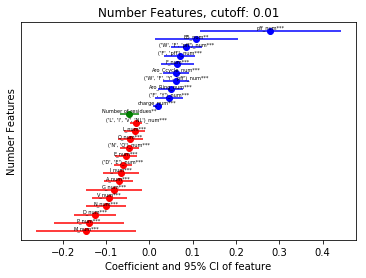

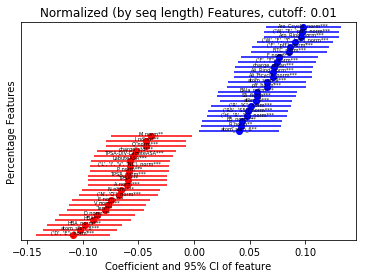

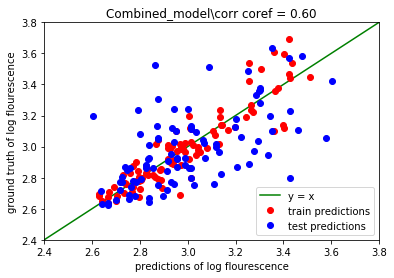

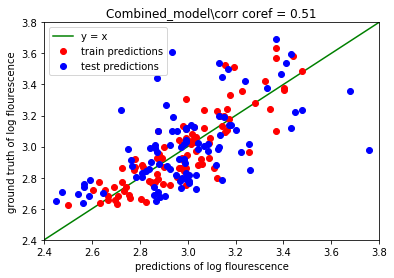

charge_surf
string
[('HBA_norm', 0.099596605390226522, -0.07483530493604959), ('charge_std', 0.10118048800928914, -0.075428009889460884), ("('F', 'Y')_norm", 0.10226320724653948, 0.075830508642867972), ('TPSA_norm', 0.1063813851351969, -0.077342300335665914), ("('F', 'pff')_num", 0.10650512166765091, 0.075597017700647945), ("('W', 'F', 'Y', 'pff')_normSA", 0.10720421109806888, 0.077640833152133229), ('Aro_Ring_norm', 0.10904109236671655, 0.07830317306614834), ('atom_sum_8', 0.10978105513771064, -0.078568410073732331), ("('W', 'F', 'pff')_num", 0.11116874016054579, 0.07865209215569724), ('F_normSA', 0.11747069755201578, 0.081273514123209364), ("('W', 'F', 'Y', 'pff')_norm", 0.1227779344436486, 0.083089170981678909), ('F_norm', 0.12912571872497858, 0.085210014732079994), ("('D', 'E')_num", 0.13047188365716944, -0.056550793145166908), ("('W', 'F', 'pff')_normSA", 0.13926352506869299, 0.088491785189360947), ("('F', 'pff')_normSA", 0.14311111196800574, 0.089705886536170884), ('Aro_Ccycle_no

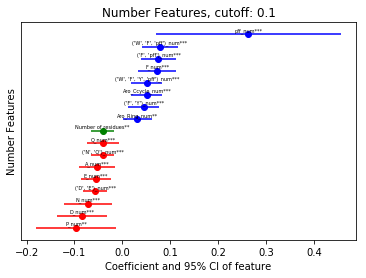

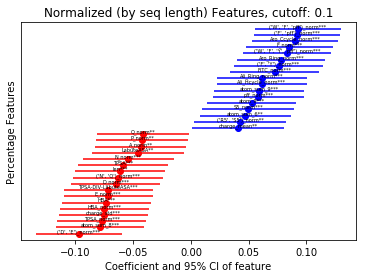

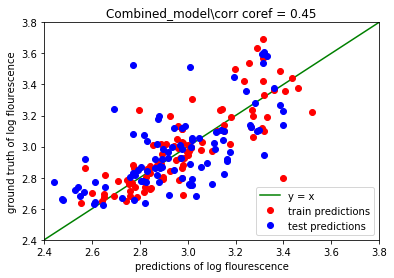

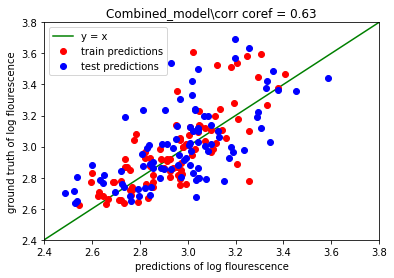

charge_surf
string
[('F_num', 0.11879967048288853, 0.082670341613917619), ("('F', 'Y')_norm", 0.11957723386045782, 0.080162429553832529), ("('W', 'F', 'Y', 'pff')_normSA", 0.12023183811950922, 0.080381547550657267), ('TPSA_norm', 0.12574307569042031, -0.082203187759421495), ('charge_std', 0.13204663153869578, -0.084238433743937649), ("('F', 'pff')_num", 0.13303545165661845, 0.083373024347440608), ("('W', 'F', 'Y', 'pff')_norm", 0.13758832674049248, 0.085987914192754436), ("('W', 'F', 'pff')_num", 0.13831527391798082, 0.085709092885169383), ('F_normSA', 0.13996325376635976, 0.086726862424340218), ('atom_sum_8', 0.14056017176761815, -0.086911602865839641), ('HBA_norm', 0.14299563017497341, -0.087661319376200558), ('Aro_Ccycle_norm', 0.14871516892663994, 0.089397269518786057), ('F_norm', 0.15149614304335779, 0.090229262573887331), ("('D', 'E')_num", 0.15724075625821254, -0.070062188712681078), ("('W', 'F', 'pff')_normSA", 0.15790512845939519, 0.092118050314400221), ("('F', 'pff')_normSA",

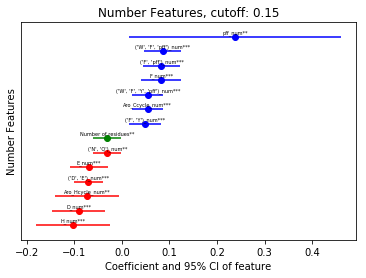

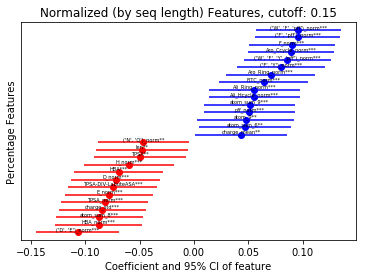

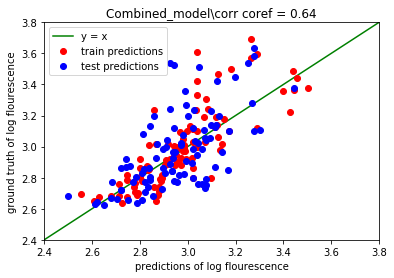

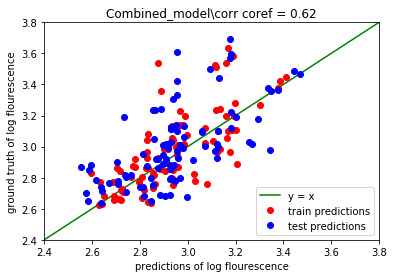

charge_surf
string
[('TPSA_norm', 0.14420640721651623, -0.091112787428306086), ("('W', 'F', 'Y', 'pff')_norm", 0.14678095930789858, 0.091922518720717966), ('F_num', 0.14797531747418258, 0.096355323602543591), ('Aro_Ccycle_norm', 0.14928517238809158, 0.092703342185349799), ('E_norm', 0.15089207824664619, -0.093200936212948837), ('E_normSA', 0.15266457323910165, -0.093746743146189845), ('charge_std', 0.16027218919355457, -0.096054151365634347), ('F_normSA', 0.16342017365671457, 0.096992887521961849), ("('W', 'F', 'pff')_num", 0.16457786228461768, 0.096751818878345441), ("('F', 'pff')_num", 0.16497327343462431, 0.097911913252505853), ('atom_sum_8', 0.16722583037478145, -0.098115751683736457), ("('W', 'F', 'pff')_normSA", 0.16750713064425693, 0.098198240107306267), ('HBA_norm', 0.17068873422152142, -0.099126434159973881), ('F_norm', 0.17657142682602289, 0.10082013347418166), ("('W', 'F', 'pff')_norm", 0.18522058906125116, 0.10325989649061161), ("('F', 'pff')_normSA", 0.18643065147302473, 0

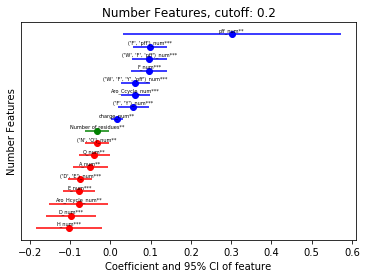

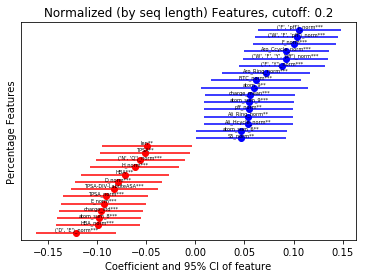

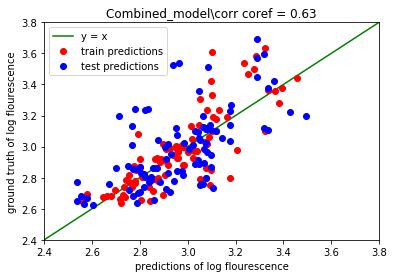

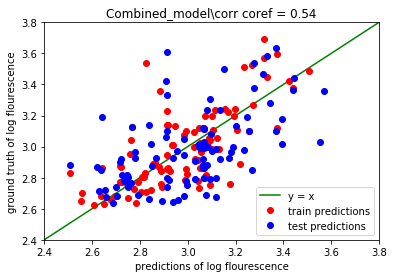

charge_surf
string
[("('F', 'Y')_norm", 0.1477263512553818, 0.088257182456039057), ("('W', 'F', 'Y', 'pff')_normSA", 0.14848457012946681, 0.08848338656447273), ('F_num', 0.15917313845818548, 0.08862551928680365), ('Aro_Ccycle_norm', 0.16203383562787776, 0.092432336137306961), ('HBA_norm', 0.16350101683774121, -0.092849870466559209), ("('W', 'F', 'Y', 'pff')_norm", 0.1678778697445239, 0.094084438650890889), ('atom_sum_8', 0.17197204473426808, -0.095224784990793551), ('F_normSA', 0.17290370314835046, 0.095482376684391634), ("('F', 'pff')_num", 0.17486431351754939, 0.089262916827552649), ('TPSA-DIV-LabuteASA', 0.18749348332146176, -0.099429249660521593), ('F_norm', 0.18867429690200554, 0.099741855547584662), ("('W', 'F', 'pff')_num", 0.19258037884627333, 0.094366770867474886), ("('F', 'pff')_normSA", 0.19373249714444307, 0.10107001064173281), ("('W', 'F', 'pff')_normSA", 0.19982432990642263, 0.1026467624236206), ("('F', 'pff')_norm", 0.20498556605256002, 0.10396393618381397), ('charge_std

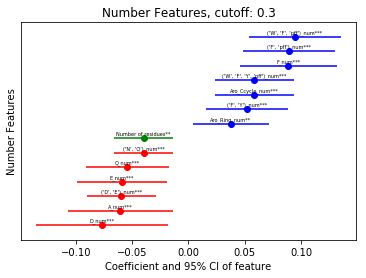

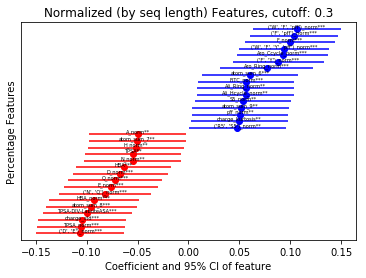

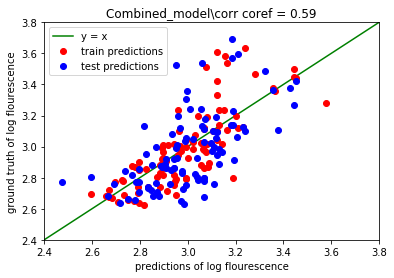

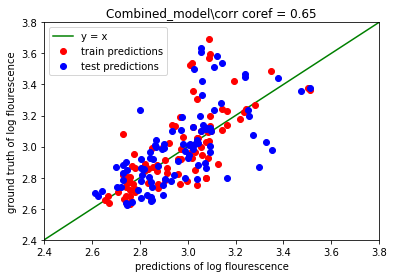

In [11]:
for cutoff in [0.01,0.1,0.15,0.2,0.3]:
    #weights for each cluster == 1     
    cluster = fcluster(Y, cutoff, criterion='distance')
    test = test.set_value(test.index,'weight0',cluster)
    test['weight'] = 1.0/test['weight0'].map(collections.Counter(fcluster(Y, cutoff, criterion='distance')))#1/(1+rho*(len(y)/(len(pd.unique(cluster))-1)))

    dictt = collections.Counter(np.concatenate(test['list'].values))

    for i in test.keys():
        try:
            if np.std(test[i])==0:
                del test[i]
        except : None
    dictt_name = {}
    if True:
        results = []
        for i in list(test.keys())[15:]:
            if 'weight' not in i and 'Lg_Flr' not in i:
                try:
                    X,Y1,Y2 = [],[],[]
                    clf = linear_model.LinearRegression()
                    temptrain  = StandardScaler().fit(test[[i,]],weights=test['weight']).transform(test[[i,]])
                    ids_non_zero = test[test[i]!=0].index
                    if 'num' in i or 'res_list' in i or i in ['atom_1', 'atom_6', 'atom_7', 'atom_8', 'atom_9', 'atom_16', 'atom_len', 'atom_size']: #do not scale count features. 
                        temptrain = test[[i,]].values #not scaled
                    temptrain2 = np.concatenate([temptrain*0+1,temptrain],1)
                    preds = clf.fit(temptrain,np.log10(test['Mean_Flr_intensity']),sample_weight=test['weight']).predict(temptrain)
                    # equailvalent ~ inv(X.T*W*X)*X.T*W*Y, analytic form of linear regression
                    W=np.diag(test['weight'])
                    X=temptrain2
                    y=np.log10(test['Mean_Flr_intensity'])
                    B=np.matmul(np.linalg.inv(np.matmul(np.matmul(X.T,W),X)) ,np.matmul(np.matmul(X.T,W),y))
                    preds = np.matmul(B,X.T)
                    se = np.sum(
                        (test['weight']*(preds-np.log10(test['Mean_Flr_intensity']))**2)
                        )*np.linalg.inv(
                             np.matmul(np.matmul(temptrain2.T,np.diag(test['weight'])),temptrain2)
                             )[-1,-1]
                    dof = sum(test['weight'])**2/sum(test['weight']**2)
                    se = 2.0*(se/dof)**.5

                    if  (clf.coef_[0]-2*se/2 >0 or clf.coef_[0]+2*se/2  <0) and r2_score(np.log10(test['Mean_Flr_intensity']),preds,sample_weight=test['weight']) < 0.7:
                        dictt_name[i] = (i,r2_score(np.log10(test['Mean_Flr_intensity']),preds,sample_weight=test['weight']),
                                 clf.coef_[0],se,[clf.coef_[0]-se,clf.coef_[0]+se],ids_non_zero)
                        results += [(i,r2_score(np.log10(test['Mean_Flr_intensity']),preds,sample_weight=test['weight']),
                                     clf.coef_[0],se,[clf.coef_[0]-se,clf.coef_[0]+se],ids_non_zero)]

                except  : print (i)
        print ([x[:3] for x in sorted(results,key =  lambda x : x[1])[-20:]])
        plot_LR_coefficient(results,cutoff,test)
        


R_num


/home/leexa/anaconda3/envs/stapled_peptide/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


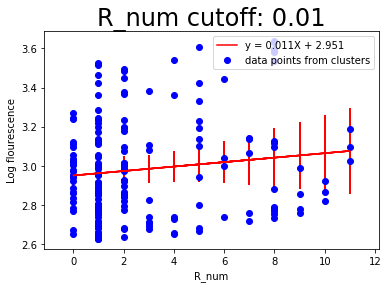

('W', 'F', 'pff')_num


/home/leexa/anaconda3/envs/stapled_peptide/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


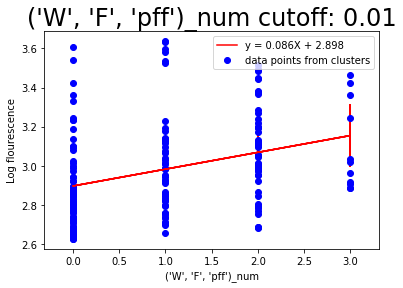

('L', 'I', 'V', 'NL')_num


/home/leexa/anaconda3/envs/stapled_peptide/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


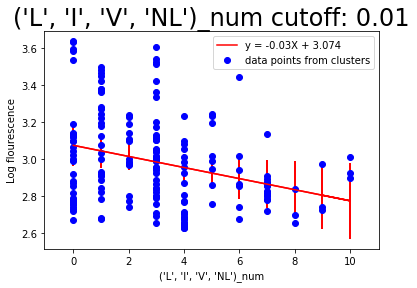

/home/leexa/anaconda3/envs/stapled_peptide/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


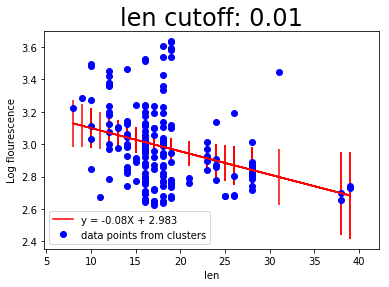

R_num


/home/leexa/anaconda3/envs/stapled_peptide/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


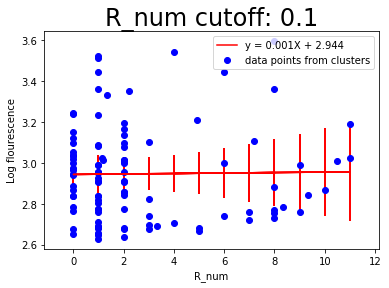

('W', 'F', 'pff')_num


/home/leexa/anaconda3/envs/stapled_peptide/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


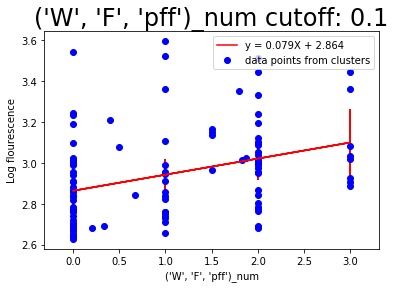

('L', 'I', 'V', 'NL')_num


/home/leexa/anaconda3/envs/stapled_peptide/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


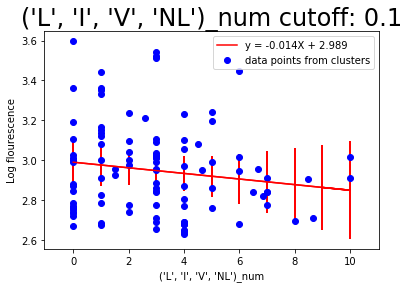

/home/leexa/anaconda3/envs/stapled_peptide/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


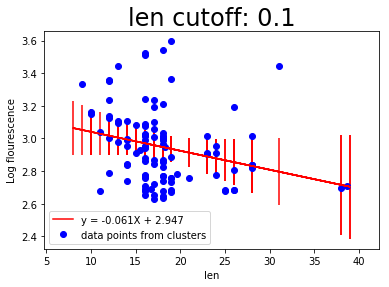

R_num


/home/leexa/anaconda3/envs/stapled_peptide/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


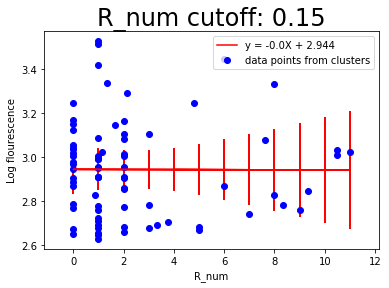

('W', 'F', 'pff')_num


/home/leexa/anaconda3/envs/stapled_peptide/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


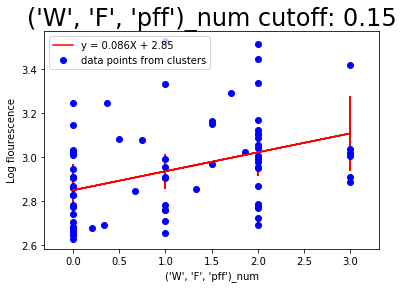

('L', 'I', 'V', 'NL')_num


/home/leexa/anaconda3/envs/stapled_peptide/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


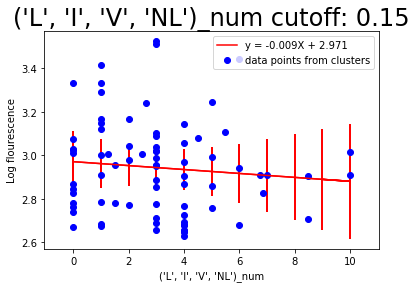

/home/leexa/anaconda3/envs/stapled_peptide/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


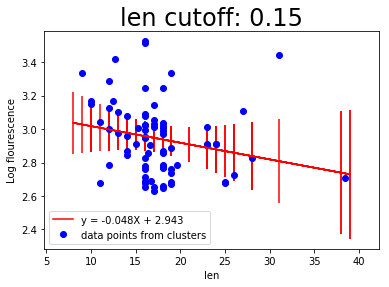

R_num


/home/leexa/anaconda3/envs/stapled_peptide/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


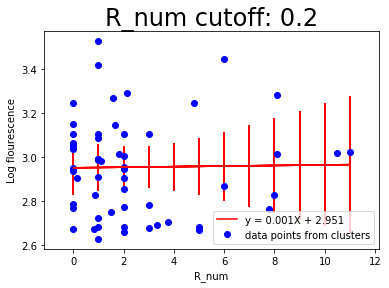

('W', 'F', 'pff')_num


/home/leexa/anaconda3/envs/stapled_peptide/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


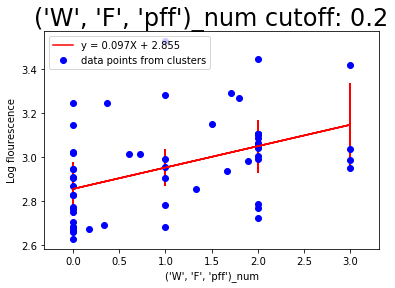

('L', 'I', 'V', 'NL')_num


/home/leexa/anaconda3/envs/stapled_peptide/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


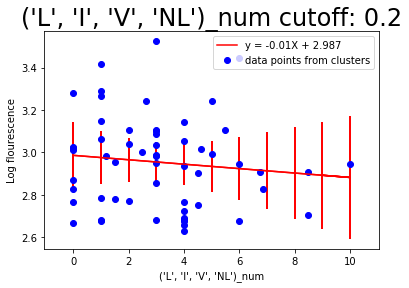

/home/leexa/anaconda3/envs/stapled_peptide/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


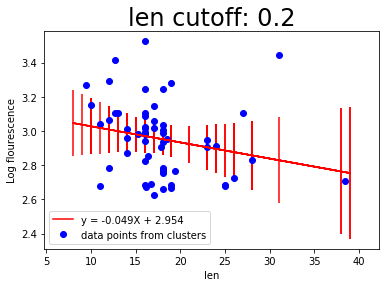

In [12]:

for cutoff in (0.01,0.1,0.15,0.2):
    cluster = fcluster(Y, cutoff, criterion='distance')
    test = test.set_value(test.index,'weight0',cluster)
    test['weight'] = 1.0/test['weight0'].map(collections.Counter(fcluster(Y, cutoff, criterion='distance')))#1/(1+rho*(len(y)/(len(pd.unique(cluster))-1)))

    def makePlot(i) :
            plt.close()
            temp = test[['Lg_Flr',i,'weight0']].groupby('weight0')[i].apply(np.mean).reset_index()
            temp = pd.merge(temp, test[['Lg_Flr',i,'weight0']].groupby('weight0')['Lg_Flr'].apply(np.mean).reset_index(),
                            on = ['weight0'])
            temptrain  = StandardScaler().fit(test[[i,]],test['weight']).transform(test[[i,]])
            if 'num' in i or 'res_list' in i or i in ['atom_1', 'atom_6', 'atom_7', 'atom_8', 'atom_9', 'atom_16', 'atom_len', 'atom_size']: #do not scale count features. 
                temptrain = test[[i,]].values
                print  (i)
            temptrain2 = np.concatenate([temptrain*0+1,temptrain],1)
            W=np.diag(test['weight'])
            X=temptrain2
            y=np.log10(test['Mean_Flr_intensity'])
            B=np.matmul(np.linalg.inv(np.matmul(np.matmul(X.T,W),X)) ,np.matmul(np.matmul(X.T,W),y))
            preds = np.matmul(B,X.T)
            se = np.sum(
                (test['weight']*(preds-np.log10(test['Mean_Flr_intensity']))**2)
                )*np.linalg.inv(
                     np.matmul(np.matmul(temptrain2.T,np.diag(test['weight'])),temptrain2)
                     )
            dof = sum(test['weight'])**2/sum(test['weight']**2)
            se = 2.0*(se/dof)
            
            err2=np.sum(
                (test['weight']*(preds-np.log10(test['Mean_Flr_intensity']))**2)
                )/(sum(test['weight'])-2)
            err2 = err2**.5
            err=np.diag(np.matmul(np.matmul(temptrain2,2*se),temptrain2.T))**.5
            B = np.round(B,3)
            plt.plot(test[i],preds,'r',label='y = %sX + %s'%(B[1],B[0]));
            plt.plot(temp[i],temp['Lg_Flr'],'bo',label='data points from clusters');
            plt.ylabel('Log flourescence');
            #plt.errorbar(test[i],preds,color='green',yerr=err2*2,label='regresion sigma');
            plt.errorbar(test[i],preds,color='red',yerr=err*2);
            axes = plt.axes()
            xlim = axes.get_xlim()
            # example of how to zoomout by a factor of 0.1
            factor = 0.1
            plt.title(i+' cutoff: '+str(cutoff),fontsize=24)
            new_xlim = (xlim[0] + xlim[1])/2 + np.array((-0.5, 0.5)) * (xlim[1] - xlim[0]) * (1 + factor) 
            axes.set_xlim(new_xlim)
            plt.xlabel(i);plt.legend();plt.savefig('../reports/figures/%s.png'%(str(i)+str(cutoff)),bbox_inches='tight' );plt.show()

    makePlot('R_num')
    makePlot("('W', 'F', 'pff')_num")
    makePlot("('L', 'I', 'V', 'NL')_num")
    makePlot("len")

In [13]:
sum(test['weight'])**2/sum(test['weight']**2)

104.83992390820406